In [92]:
# Imports
import os
import datetime

import pytz

from scipy.signal import medfilt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

from utils.utils import load_pickle, save_pickle
from download.download import concatenate_metadata_dfs
from plotting.birdseye import Birdseye 

In [2]:
def replace_max_values(df, stid, vrbl, max_value=None):
    df_filtered = df[df["stid"] == stid].copy()
    if max_value is None:
        max_value = df_filtered[vrbl].max()
        
    # Replace the maximum values with NaN
    df_filtered.loc[df_filtered[vrbl] == max_value, vrbl] = np.nan
    return df_filtered.interpolate(method='linear')

def apply_median_filter(df, stid, vrbl, kernel_size):
    df_filtered = df[df["stid"] == stid].copy()
   
    # Apply a median filter with a kernel size of your choice
    # The kernel size determines how many neighboring points are considered (choose an odd number)
    # Have to use 32 bit or higher for this
    df_filtered[vrbl] = medfilt(df_filtered[vrbl].astype('float32'), kernel_size=kernel_size)
    return df_filtered

def filter_snow_depth(df, stid, vrbl, kernel_size):
    # Apply median filter to the snow depth values
    filtered_df = apply_median_filter(replace_max_values(df, stid, vrbl), stid, vrbl, kernel_size=kernel_size)
    return filtered_df

def plot_two_years(stids, df_2023, df_2024, vrbl, kernel_lookup=None):
    def get_kernel(stid, kernel_lookup):
        return kernel_lookup[stid] if kernel_lookup is not None else 1
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)    
    # Plot for df_2023
    for stid in stids:
        kernel_size = get_kernel(stid, kernel_lookup)
        subset = filter_snow_depth(df_2023[df_2023["stid"] == stid], stid, "snow_depth", kernel_size)
        axs[0].plot(subset.index, subset[vrbl], label=stid)
    
    # Plot for df_2024
    for stid in stids:
        kernel_size = get_kernel(stid, kernel_lookup)
        subset = filter_snow_depth(df_2024[df_2024["stid"] == stid], stid, "snow_depth", kernel_size)
        axs[1].plot(subset.index, subset[vrbl], label=stid)
    
    # Set titles, labels, and customize plots
    axs[0].set_title(f"{vrbl}: Nov 2022 - Apr 2023")
    axs[0].set_xlabel("Date")
    # axs[0].set_ylabel("Snow Depth (mm)")
    # axs[0].set_ylim(0, 750)
    
    axs[1].set_title(f"{vrbl}: Nov 2023 - Mar 2024")
    axs[1].set_xlabel("Date")
    # axs[1].set_ylim(0, 750)
    
    # Add legend to the first plot
    axs[0].legend()
    
    plt.tight_layout()
    plt.show()
    
def plot_before_after(df, stid, vrbl, filtered_df):
    # Plotting before-and-after effect of the replacement function
    plt.figure(figsize=(12, 6))

    # Original data
    plt.plot(df[df["stid"] == stid].index, df[df["stid"] == stid][vrbl], label='Original', alpha=0.7)

    # Filtered data
    plt.plot(filtered_df.index, filtered_df[vrbl], label='After Removing Max Value', color='red')

    plt.title(f'Snow Depth for {stid} Before and After Removing Maximum Value')
    plt.xlabel('Date')
    plt.ylabel('Snow Depth (mm)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def plot_filtered_data(filtered_dfs, top_stations_percentage, region, stid_list=None):
    """Plot the filtered snow depth time series for the top 5 STIDs in the specified region on a single plot.

    Args:
        filtered_dfs (list): A list of DataFrames, each containing the filtered data for a specific STID.
        top_stations_percentage (pd.DataFrame): A DataFrame containing the top STIDs for each region.
        region (str): The region to plot the data for.
    """
    # Create a color palette with 5 different colors
    colors = plt.cm.get_cmap('hsv', 7)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, filtered_df in enumerate(filtered_dfs):
        if stid_list is None:
            stid = top_stations_percentage[top_stations_percentage["region"] == region].iloc[i]["stid"]
        else:
            stid = stid_list[i]
        filtered_df.plot(y="snow_depth", ax=ax, color=colors(i), label=f"STID: {stid}")

    # Set labels and title
    ax.set_ylabel("Snow Depth (mm)")
    ax.set_xlabel("Date")
    plt.title(f"Filtered Snow Depth Time Series for Top 5 STIDs in {region}")

    # Add a legend
    plt.legend()

    plt.tight_layout()
    plt.show()
    return
    
def filter_and_plot_data(df, top_stations_percentage, region, kernel_size, stid_list=None):
    """Filter snow_depth values for the stids for a specific region and plot the filtered data.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        top_stations_percentage (pd.DataFrame): A DataFrame containing the top STIDs for each region.
        region (str): The region to filter and plot the data for.
    """
    if stid_list is None:
        stid_list = top_stations_percentage[top_stations_percentage["region"] == region]["stid"].values
    filtered_dfs = []
    for stid in stid_list:
        filtered_df = filter_snow_depth(df, stid, "snow_depth", kernel_size)
        filtered_dfs.append(filtered_df)

    plot_filtered_data(filtered_dfs, top_stations_percentage, region, stid_list)
    return

def compare_region_timeseries(df, top_stations_percentage, regions_to_plot):
    """Plot the filtered snow depth time series for the specified regions on a single plot.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        top_stations_percentage (pd.DataFrame): A DataFrame containing the top STIDs for each region.
        regions_to_plot (list): The regions to plot the data for.
    """
    fig, axes = plt.subplots(1, len(regions_to_plot), figsize=(20, 8))  # One column for each region

    for i, region in enumerate(regions_to_plot):
        stids_region = top_stations_percentage[top_stations_percentage["region"] == region]["stid"].values
        elevations = df[df["stid"].isin(stids_region)]['elevation'].unique()
        quartiles = np.quantile(elevations, [0.25, 0.75])

        legend_info = []  # To store handles, labels, and elevations

        for stid in stids_region:
            df_subset = df[df["stid"] == stid]
            if not df_subset.empty:
                elevation = df_subset['elevation'].iloc[0]
                linestyle = '-' if elevation <= quartiles[0] else ':'
                line, = axes[i].plot(df_subset.index, df_subset["filtered_snow_depth"], linestyle=linestyle, label=f"{stid} ({elevation}m)")
                # Append handle, label, and elevation
                legend_info.append((line, f"{stid} ({int(elevation)}m)", elevation))

        # Sort legend_info by elevation
        legend_info.sort(key=lambda x: x[2])
        # Unpack sorted legend_info to create the legend
        handles, labels, _ = zip(*legend_info)
        axes[i].legend(handles, labels)

        axes[i].set_title(f"Filtered Snow Depth: {region.replace('_', ' ').title()}")
        axes[i].set_xlabel("Date")
        axes[i].set_ylabel("Snow Depth (mm)")

    plt.tight_layout()
    plt.show()

def plot_elevation_stations(df, top_stations_percentage, elevation_categories, regions, elevation_type):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    def get_stids_region(region):
        return top_stations_percentage[top_stations_percentage["region"] == region]["stid"].values

    def get_combined_stids_region(region):
        assert len(region) > 1
        stids = []
        for r in region:
            stids.extend(get_stids_region(r))
        return stids

    for i, region in enumerate(regions):
        if isinstance(region, tuple):
            stids_region = get_combined_stids_region(region)
            region_str = "uinta_merge"
        else:
            stids_region = get_stids_region(region)
            region_str = region.replace('_', ' ').title()
        stids_filtered = [stid for stid in stids_region if elevation_categories[stid] == elevation_type]

        for stid in stids_filtered:
            df_stid = df[df["stid"] == stid]
            if not df_stid.empty:
                altitude = df_stid['elevation'].iloc[0]
                linestyle = '--' if df_stid['region'].iloc[0] == 'uinta_mtns' else '-'
                df_stid.plot(y="filtered_snow_depth", ax=axes[i//2, i%2], label=f"{stid} ({altitude}m)", linestyle=linestyle)

        axes[i//2, i%2].set_title(f"{elevation_type.capitalize()}-Elevation Stations in {region_str}")
        axes[i//2, i%2].set_xlabel("Date")
        axes[i//2, i%2].set_ylabel("Snow Depth (mm)")

        # Create the legend for each subplot
        axes[i//2, i%2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=8, framealpha=0.5)

        # Change the font size for the x-axis ticks
        axes[i//2, i%2].tick_params(axis='x', labelsize=8)

    # Adjust the layout to give more space for the legends
    plt.subplots_adjust(bottom=0.2)

    # Double the typical number of x-axis ticks for the date
    for ax in axes.flat:
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))

    plt.tight_layout()
    plt.show()

In [3]:
# Get data
data_root = "./data"
data_fname = "df_obs_pp.h5"
metadata_fname = "df_metadata.h5"

df_obs_fpath = os.path.join(data_root, data_fname)
df_meta_fpath = os.path.join(data_root, metadata_fname)

regions = ["uinta_basin", "uinta_mtns", "nslv", "cslv", "sslv"]
start_date = datetime.datetime(2022, 11, 1, 0, 0, 0)
end_date = datetime.datetime(2024, 3, 1, 0, 0, 0)
df_meta = load_pickle(df_meta_fpath)
df_obs = pd.read_hdf(df_obs_fpath, key='df_obs')

stids = df_obs["stid"].unique()
# stids
df_obs_winter = df_obs[df_obs.index.month.isin([11, 12, 1, 2, 3])]

In [4]:
df_obs_winter.head(3)

,air_temp,altimeter,dew_point_temperature,elevation,latitude,longitude,ozone_concentration,pressure,region,relative_humidity,sea_level_pressure,snow_depth,snow_water_equiv,soil_temp,solar_radiation,stid,wind_direction,wind_gust,wind_speed
date_time,,,,,,,,,,,,,,,,,,,
2022-11-01 00:00:00+00:00,12.0,NaN,NaN,1600.0,40.4375,-109.5,NaN,NaN,uinta_basin,30.09375,NaN,NaN,NaN,NaN,NaN,KVEL,0.0,NaN,0.0
2022-11-01 00:05:00+00:00,11.0,NaN,NaN,1600.0,40.4375,-109.5,NaN,NaN,uinta_basin,34.65625,NaN,NaN,NaN,NaN,NaN,KVEL,0.0,NaN,0.0
2022-11-01 00:10:00+00:00,11.0,NaN,NaN,1600.0,40.4375,-109.5,NaN,NaN,uinta_basin,34.65625,NaN,NaN,NaN,NaN,NaN,KVEL,0.0,NaN,0.0


In [5]:
# 

In [6]:
# Step 1 & 2: Group by 'stid' and 'region', then calculate the count of total and non-null observations for 'snow_depth'
station_analysis = df_obs_winter.groupby(['stid', 'region']).agg(
    total_observations=('snow_depth', 'size'),  # Total number of observations (including nulls)
    valid_observations=('snow_depth', 'count')  # Count of non-null observations
).reset_index()

# Step 3: Calculate the percentage of valid observations
station_analysis['valid_percentage'] = (station_analysis['valid_observations'] / station_analysis['total_observations']) * 100

# Sort the data by 'valid_percentage' and then 'total_observations' for a secondary sort in case of ties in percentage
station_analysis = station_analysis.sort_values(by=['region', 'valid_percentage', 'total_observations'], ascending=[True, False, False])

# Filter for top stations per region based on this percentage
# Assuming you still want the top 5 stations per region
top_stations_percentage = station_analysis.groupby('region').head(15)

top_stations_percentage


,stid,region,total_observations,valid_observations,valid_percentage
294,HERUT,cslv,85199,85199,100.000000
359,NHMU,cslv,85188,85188,100.000000
493,SUNUT,cslv,85186,85186,100.000000
481,SNV,cslv,68736,68736,100.000000
340,LPTUT,cslv,64528,64528,100.000000
...,...,...,...,...,...
299,HIRU1,uinta_mtns,7069,7067,99.971707
336,LLKU1,uinta_mtns,7069,7067,99.971707
49,BCZU1,uinta_mtns,7069,7066,99.957561
295,HEWU1,uinta_mtns,7069,7066,99.957561


In [7]:
# Sort the DataFrame by its datetime index
df_obs_winter_sorted = df_obs_winter.sort_index()

# Now split the DataFrame into the specified periods
df_2023 = df_obs_winter_sorted.loc['2022-11-01':'2023-04-01']
df_2024 = df_obs_winter_sorted.loc['2023-11-01':]  # Assuming the end of your time series is within this range


In [8]:
# 15 stations per region - now we want to look at the time series to see:
# (a) if the snow time series is good enough to use (long dataset, not too many missing values, noise can be removed, etc)
# (b) what kernel to use for the filtering

# go in batches of five. 
# each batch has a dictionary of { stid: kernel_size }
# Need a list of stations we want per region 

kernel_lookup = {
    ##### CSLV #####
    "HERUT": 301, # Good time series; high frequency
    # "NHMU": 301, # REMOVE
    # "SUNUT": 301, # REMOVE
    "SNV": 301, # Good time series; high frequency
    "DVO": 501, # TODO manually remove end of 2023 with big dropout 
    
    "LPTUT": 301, # High res, good ts,
    "ELBUT": 301, # TODO High res, good ts, a square wave at start of 2024
    "SPC": 501, # TODO High res, good ts, end of 2023 has dropout 
    "HOL": 101, # Low values but long ts, high freq, low noise
    # "PNCUT": 1, # REMOVE
    
    "CLN": 201, # TODO High freq with min value noise - remove end of 2023 dropout
    "FMNU1": 201, # Good ts, high freq
    "THCU1": 101, # Good ts, high freq
    "MLDU1": 301, # Good ts, high freq
    "CDYBK": 101, # Good ts, high freq
    
    ##### NSLV #####
    "UTPW2": 301, # very noisy
    # "FMNU1": 1, # DUPLICATE
    "COOPOGNU1": 1, # not noisy
    "PWDU1": 201, # rather nosiy
    "SNFEC": 401, # very noisy
    
    # "BLPU1": 301, # lots of weird bits - REMOVE
    # "FARU1": 301, # lots of weird bits - REMOVE
    "COOPBRGU1": 1, # smooth, lower freq
    "SNI": 101, # TODO high freq, some noise - remove dropout at end of 2023
    "PCRU1": 101, # high freq, some noise
    
    # "BLTU1": 301, # too much erroneous data - REMOVE
    "LTBU1": 101, # high freq, some noise
    "COOPWEBU1": 1, # smooth, lower freq - potentially a gap in early 2024 season but low freq anyway
    "SBBWK": 301, # TODO very noisy - chop beginning and end of both years that are missing/erroneous
    "TPR": 101, # high freq, some noise
    
    ##### SSLV #####
    # "SUNUT": 1001, # DUPLICATE
    # "LPTUT": 1, # DUPLICATE 
    # "UTASG": 1001, # very noisy - REMOVE
    "BUNUT": 501, # very noisy TODO - remove end of both years dropout 
    # "PNCUT": 1, # Missing 2023?

    "TIMU1": 501, # very noisy, high freq
    "COOPPLTU1": 1,
    "COOPAMFU1": 1,
    "COOPPROU1": 1,
    "COOPLEHU1": 1,
    
    "COOPPLGU1": 1,
    "COOPFAFU1": 1,
    "SNM": 201, # noisy
    "DCC": 201, # noisy 
    "PYSU1": 201, # noisy
    
    ##### UINTA BASIN #####
    "COOPNELU1": 1, 
    "COOPALMU1": 1,
    "COOPJENU1": 1,
    "COOPFTDU1": 3, # A little noise
    "MMTU1": 151, # noisy

    "COOPROSU1": 1,
    "COOPDSNU1": 1,
    "COOPMYTU1": 1,
    "KGCU1": 301, # very noisy
    # "SPKU1": 301 # very noisy - REMOVE too much missing/erroneous
    
    "TCKU1": 301, # noisy
    "LKFU1": 1101,
    "CWHU1": 601,
    "COOPOURU1": 1,
    "UTWIS": 501,

    "TPKUT": 101,
    "CSTUT": 101,
    # "GSTPS": 101, # weird data - removed
    "CCSUT": 101,
    # "TPRUT": 1, # weird data - removed
    
    # "COOPNELU1": 1, # duplicate
    # "COOPALMU1": 1, # duplicate
    "CCKU1": 301,
    "HPSU1": 51,
    "HIRU1": 51,

    "LLKU1": 101,
    "BCZU1": 101,
    "HEWU1": 101,
    # "CHCU1": 101, # REMOVE too much weird data
    "RMLU1": 101,
    
}

/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4402/2976257859.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return df_filtered.interpolate(method='linear')
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4402/2976257859.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return df_filtered.interpolate(method='linear')
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4402/2976257859.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return df_filtered.interpolate(method='linear')
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4402/2976257859.py:8: FutureWarning: D

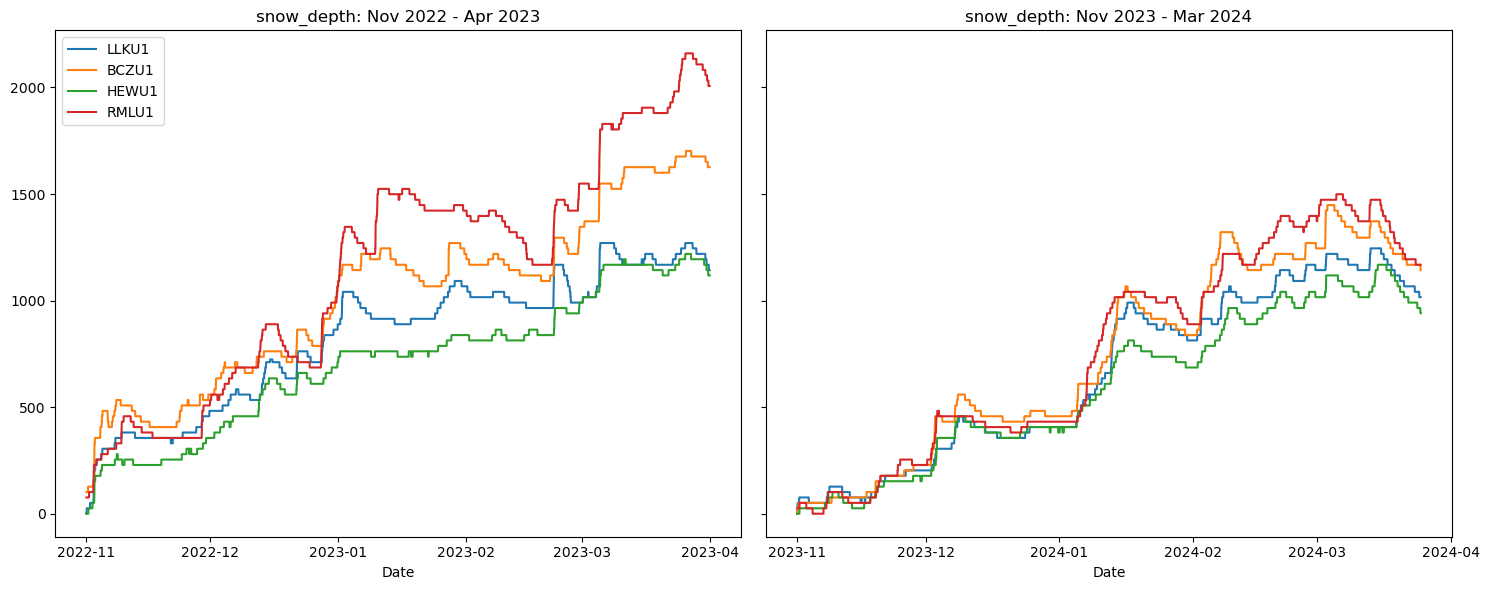

In [9]:
# stids_plot = ["HERUT", "NHMU", "SUNUT", "SNV", "DVO"]
# stids_plot = ["HERUT", "SNV", "DVO"]
# stids_plot = ["LPTUT", "ELBUT", "SPC", "HOL"]
# stids_plot = ["CLN", "FMNU1", "THCU1", "MLDU1", "CDYBK"]
# stids_plot = ["UTPW2", "COOPOGNU1", "PWDU1", "SNFEC"]
# stids_plot = ["COOPBRGU1", "SNI", "PCRU1"]
# stids_plot = ["LTBU1", "COOPWEBU1", "SBBWK", "TPR"]
# stids_plot = ["BUNUT",]
# stids_plot = ["TIMU1", "COOPPLTU1", "COOPAMFU1", "COOPPROU1", "COOPLEHU1"]
# stids_plot = ["COOPPLGU1", "COOPFAFU1", "SNM", "DCC", "PYSU1"]
# stids_plot = ["COOPNELU1", "COOPALMU1", "COOPJENU1", "COOPFTDU1", "MMTU1"]
# stids_plot = ["COOPROSU1", "COOPDSNU1", "COOPMYTU1", "KGCU1"]
# stids_plot = ["TCKU1", "LKFU1", "CWHU1", "COOPOURU1", "UTWIS"]
# stids_plot = ["TPKUT", "CSTUT", "CCSUT"]
# stids_plot = ["CCKU1", "HPSU1", "HIRU1"]
stids_plot = ["LLKU1", "BCZU1", "HEWU1", "RMLU1"]
plot_two_years(stids_plot, df_2023, df_2024, "snow_depth", kernel_lookup=kernel_lookup)

In [10]:
# Now we can add to df_2023 and df_2024 a new column, "filtered_snow_depth"
# We loop over each stid in sde_stids, and apply the median filter with the kernel size given in kernel_lookup
# This filtered time series should then go into "filtered_snow_depth" column
sde_stids = kernel_lookup.keys()
for stid in sde_stids:
    kernel_size = kernel_lookup[stid]
    # print("Filtering 2023 data")
    df_2023.loc[df_2023["stid"] == stid, "filtered_snow_depth"] = apply_median_filter(
            replace_max_values(df_2023, stid, "snow_depth"), stid, "snow_depth", kernel_size)["snow_depth"]
    # print("Filtering 2024 data")
    df_2024.loc[df_2024["stid"] == stid, "filtered_snow_depth"] = apply_median_filter(
            replace_max_values(df_2024, stid, "snow_depth"), stid, "snow_depth", kernel_size)["snow_depth"]
    
# TODO - some warnings here like interpolating dtype object, and setting with copy warning
# TODO - need to save the smoothed dataframes (df_2023 and df_2024) to disc to speed up loading next time.
df_2024.head(10)

/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4402/2976257859.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return df_filtered.interpolate(method='linear')
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4402/186477743.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023.loc[df_2023["stid"] == stid, "filtered_snow_depth"] = apply_median_filter(
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4402/2976257859.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating inst

,air_temp,altimeter,dew_point_temperature,elevation,latitude,longitude,ozone_concentration,pressure,region,relative_humidity,sea_level_pressure,snow_depth,snow_water_equiv,soil_temp,solar_radiation,stid,wind_direction,wind_gust,wind_speed,filtered_snow_depth
date_time,,,,,,,,,,,,,,,,,,,,
2023-11-01 00:00:00+00:00,1.5,NaN,NaN,2402.0,40.96875,-111.8125,NaN,NaN,cslv,NaN,NaN,203.25,45.718750,NaN,NaN,FMNU1,NaN,NaN,NaN,152.375
2023-11-01 00:00:00+00:00,7.878906,NaN,NaN,1584.0,40.28125,-110.0000,42.0,NaN,uinta_basin,19.0000,NaN,NaN,NaN,NaN,9.000000,QRS,207.000,NaN,0.627930,NaN
2023-11-01 00:00:00+00:00,3.199219,NaN,NaN,2872.0,40.75000,-109.6875,NaN,NaN,uinta_mtns,NaN,NaN,0.00,20.312500,NaN,NaN,TCKU1,NaN,NaN,NaN,0.000
2023-11-01 00:00:00+00:00,8.890625,NaN,NaN,1294.0,41.09375,-112.0625,NaN,NaN,nslv,28.0000,NaN,NaN,NaN,NaN,NaN,AR623,NaN,0.000000,0.000000,NaN
2023-11-01 00:00:00+00:00,8.45,NaN,NaN,1779.0,40.81250,-111.3750,NaN,NaN,cslv,37.9375,NaN,NaN,NaN,5.621094,56.812500,UTWAN,133.250,2.156250,1.012695,NaN
2023-11-01 00:00:00+00:00,NaN,NaN,NaN,1329.0,40.65625,-111.9375,NaN,NaN,cslv,NaN,NaN,NaN,NaN,11.906250,NaN,UT2SR,NaN,NaN,NaN,NaN
2023-11-01 00:00:00+00:00,8.890625,NaN,NaN,1304.0,41.09375,-112.0625,NaN,NaN,nslv,37.0000,NaN,NaN,NaN,NaN,NaN,F5963,NaN,1.790039,0.000000,NaN
2023-11-01 00:00:00+00:00,3.556,NaN,NaN,2230.0,40.62500,-111.5000,NaN,NaN,cslv,38.0000,NaN,622.50,NaN,NaN,NaN,DVE,130.750,1.034180,0.957031,NaN
2023-11-01 00:00:00+00:00,3.699219,NaN,NaN,2446.0,39.93750,-111.6250,NaN,NaN,sslv,NaN,NaN,0.00,5.078125,NaN,NaN,PYSU1,NaN,NaN,NaN,0.000


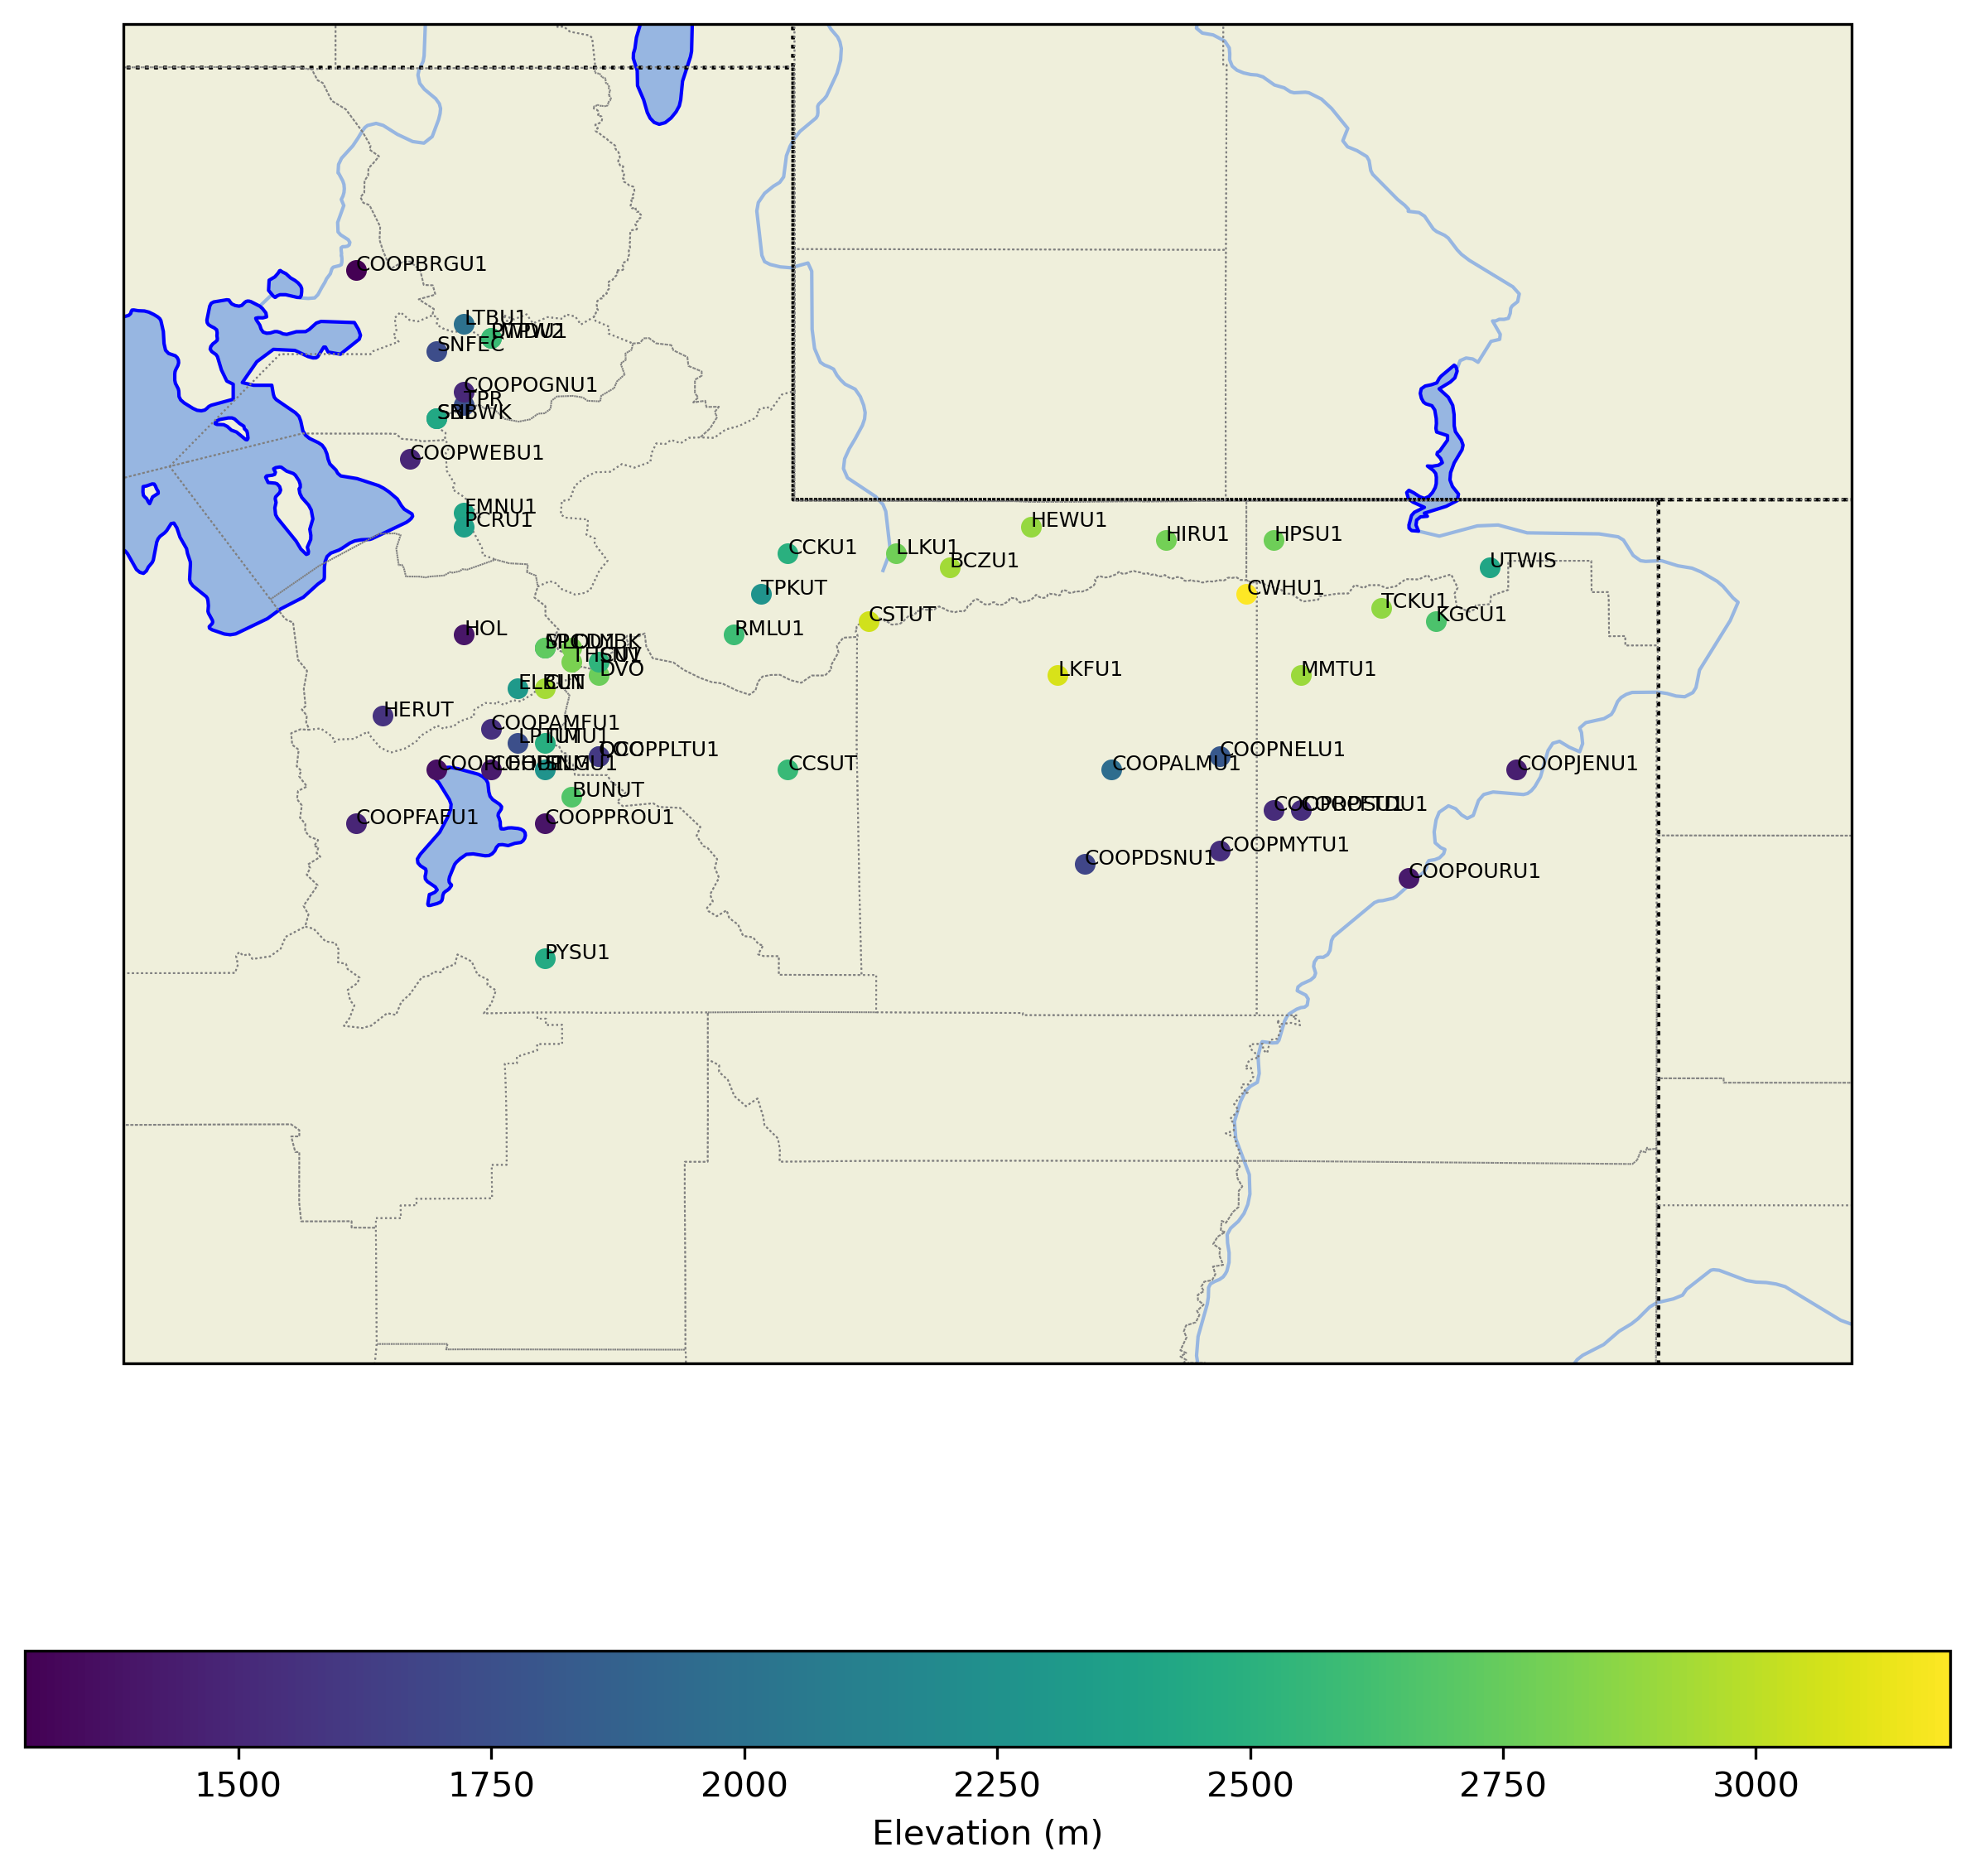

In [11]:
# Let's plot the stids in sde_stids, using df_2024 for station information, to see our best snow_depth time series' stid locations
# Todo: plot the marker as elevation
# TOdo: speed up this function
# TODO: consider a colour map for elevation that is easier to interpret
be = Birdseye("./figures/sde_stids_map.png", figsize=(10, 10))
be.plot_all_stations(df_2024[df_2024["stid"].isin(sde_stids)], marker_elevation=True)
# show figure 

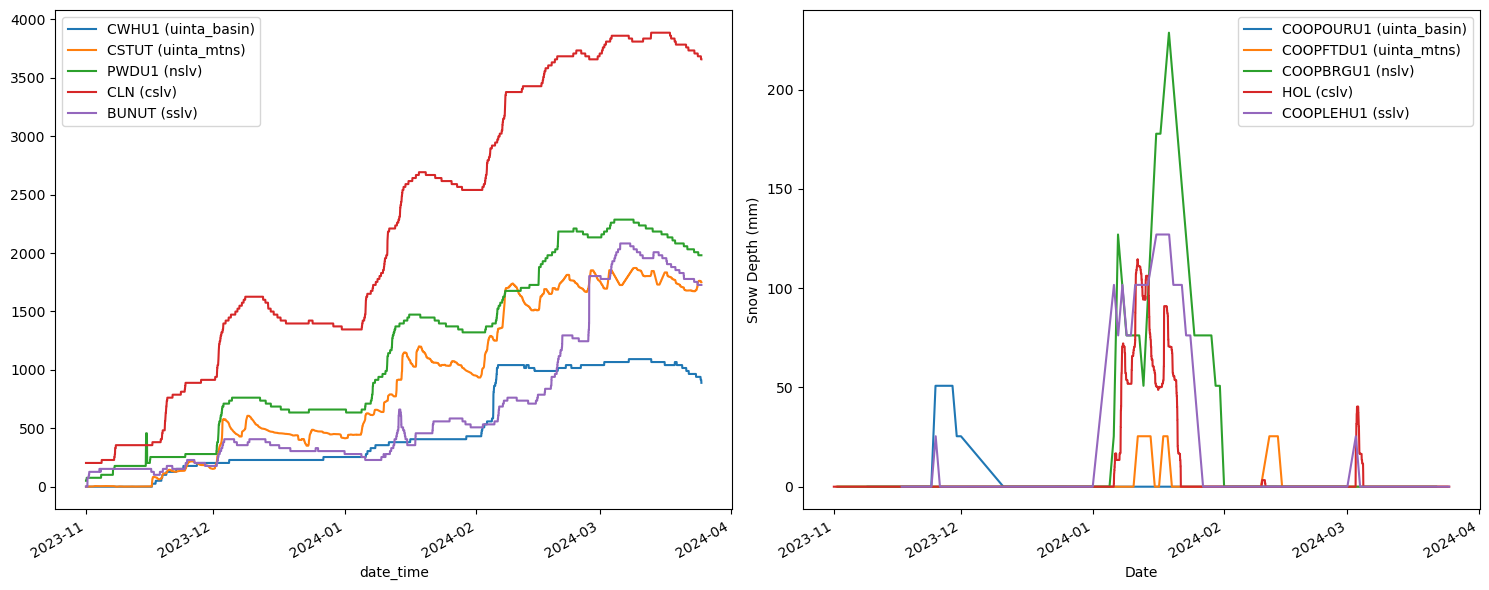

In [12]:
# Let's check df_2024 filtered_snow_depth for the stations in sde_stids
# Let's plot a high-elevation station and a low-elevation station per region 
# one-row, two-column
# High-elevation on the left and low-elevation on the right
# We will plot the filtered_snow_depth and label the stid with a legend

# Let the y-axes vary because low-level stations will have lower snow_depth values
fig, axes = plt.subplots(1, 2, figsize=(15, 6),)

# for each region, let's pick the stid with the highest elevation and the lowest elevation
# we will plot the filtered_snow_depth for these two stations in their respective axis 
for i, region in enumerate(regions):
    # Get the stids for the region
    stids_region = top_stations_percentage[top_stations_percentage["region"] == region]["stid"].values
    # Get the highest and lowest elevation stids
    stid_high = df_2024[df_2024["stid"].isin(stids_region)].sort_values(by="elevation", ascending=False).iloc[0]["stid"]
    stid_low = df_2024[df_2024["stid"].isin(stids_region)].sort_values(by="elevation", ascending=True).iloc[0]["stid"]
    
    # Plot the high-elevation station
    # The label is the stid and the region in this loop iteration
    df_2024[df_2024["stid"] == stid_high].plot(y="filtered_snow_depth", ax=axes[0], label=f"{stid_high} ({region})")
    # Plot the low-elevation station
    df_2024[df_2024["stid"] == stid_low].plot(y="filtered_snow_depth", ax=axes[1], label=f"{stid_low} ({region})")
    
    # Set the title and labels
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Snow Depth (mm)")
    axes[1].legend()
    
plt.tight_layout()
plt.show()




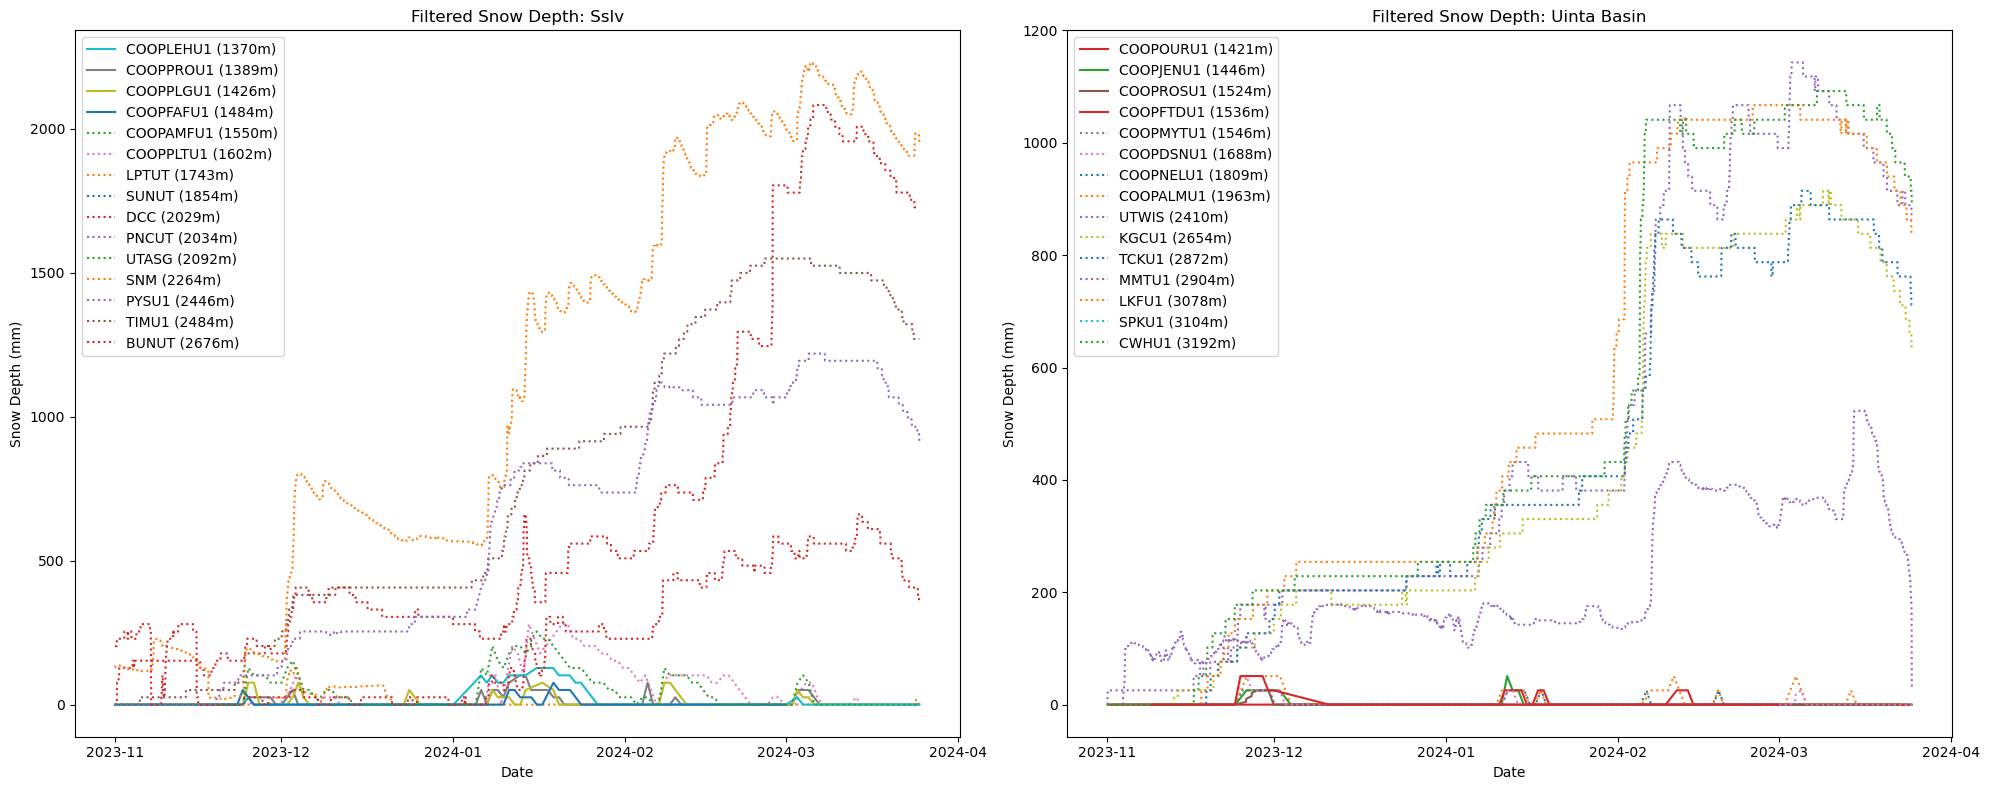

In [13]:

compare_region_timeseries(df_2024, top_stations_percentage, ["sslv", "uinta_basin"])

In [14]:
# 2000 m in the Uinta Basin or Uinta Mountains is a good cutoff for high elevation
# 1600 m in the Salt Lake Valley (nslv, cslv, sslv) is a good cutoff for high elevation

# Let's create a dictionary that has { stid : x } for stid in sde_stids, and where x is a string from {'high', 'low'}.
# We will use this to categorise the high-elevation and low-elevation stations for each region

elevation_cutoffs = {
    "uinta_basin": 2000,
    "uinta_mtns": 2000,
    "nslv": 1600,
    "cslv": 1600,
    "sslv": 1600
}

elevation_categories = {}
for region in regions:
    stids_region = top_stations_percentage[top_stations_percentage["region"] == region]["stid"].values
    for stid in stids_region:
        elevation = df_2024[df_2024["stid"] == stid]["elevation"].iloc[0]
        if elevation > elevation_cutoffs[region]:
            elevation_categories[stid] = "high"
        else:
            elevation_categories[stid] = "low"
            
elevation_categories


{'COOPNELU1': 'low',
 'COOPALMU1': 'low',
 'COOPJENU1': 'low',
 'COOPFTDU1': 'low',
 'MMTU1': 'high',
 'COOPROSU1': 'low',
 'COOPDSNU1': 'low',
 'COOPMYTU1': 'low',
 'KGCU1': 'high',
 'SPKU1': 'high',
 'TCKU1': 'high',
 'LKFU1': 'high',
 'CWHU1': 'high',
 'COOPOURU1': 'low',
 'UTWIS': 'high',
 'TPKUT': 'high',
 'CSTUT': 'high',
 'GSTPS': 'high',
 'CCSUT': 'high',
 'TPRUT': 'high',
 'CCKU1': 'high',
 'HPSU1': 'high',
 'HIRU1': 'high',
 'LLKU1': 'high',
 'BCZU1': 'high',
 'HEWU1': 'high',
 'CHCU1': 'high',
 'UTPW2': 'high',
 'FMNU1': 'high',
 'COOPOGNU1': 'low',
 'PWDU1': 'high',
 'SNFEC': 'high',
 'BLPU1': 'high',
 'FARU1': 'high',
 'COOPBRGU1': 'low',
 'SNI': 'high',
 'PCRU1': 'high',
 'BLTU1': 'high',
 'LTBU1': 'high',
 'COOPWEBU1': 'low',
 'SBBWK': 'high',
 'TPR': 'high',
 'HERUT': 'low',
 'NHMU': 'low',
 'SUNUT': 'high',
 'SNV': 'high',
 'LPTUT': 'high',
 'DVO': 'high',
 'ELBUT': 'high',
 'SPC': 'high',
 'HOL': 'low',
 'PNCUT': 'high',
 'CLN': 'high',
 'THCU1': 'high',
 'CDYBK': 'hi

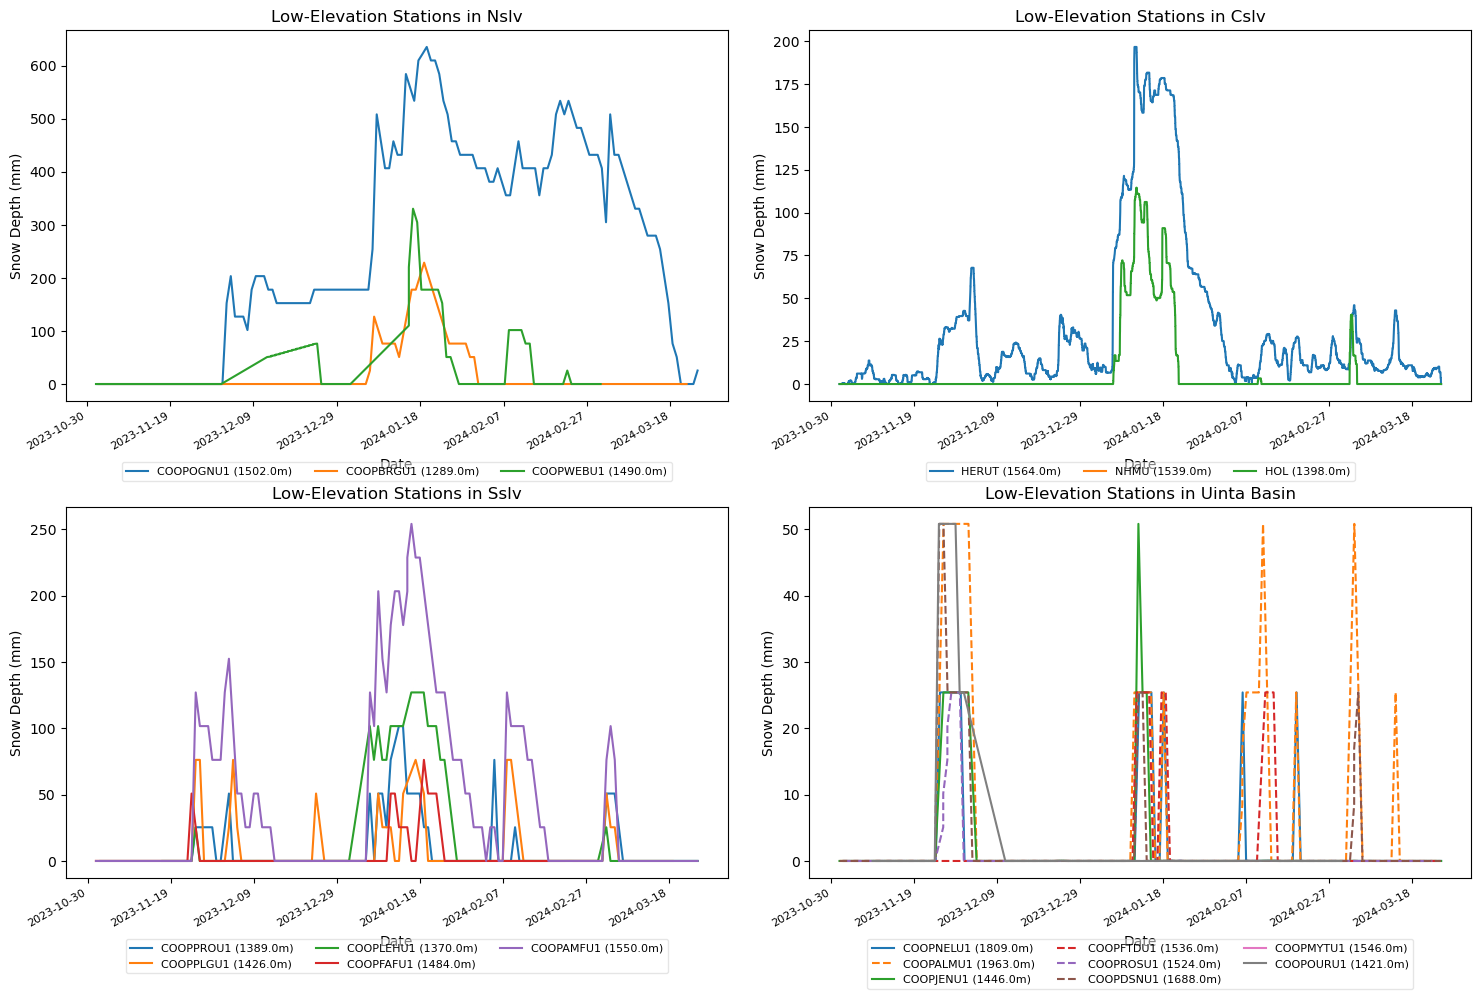

In [15]:
plot_elevation_stations(df_2024, top_stations_percentage, elevation_categories,
                            ["nslv", "cslv", "sslv", "uinta_basin"], "low")

### Case studies

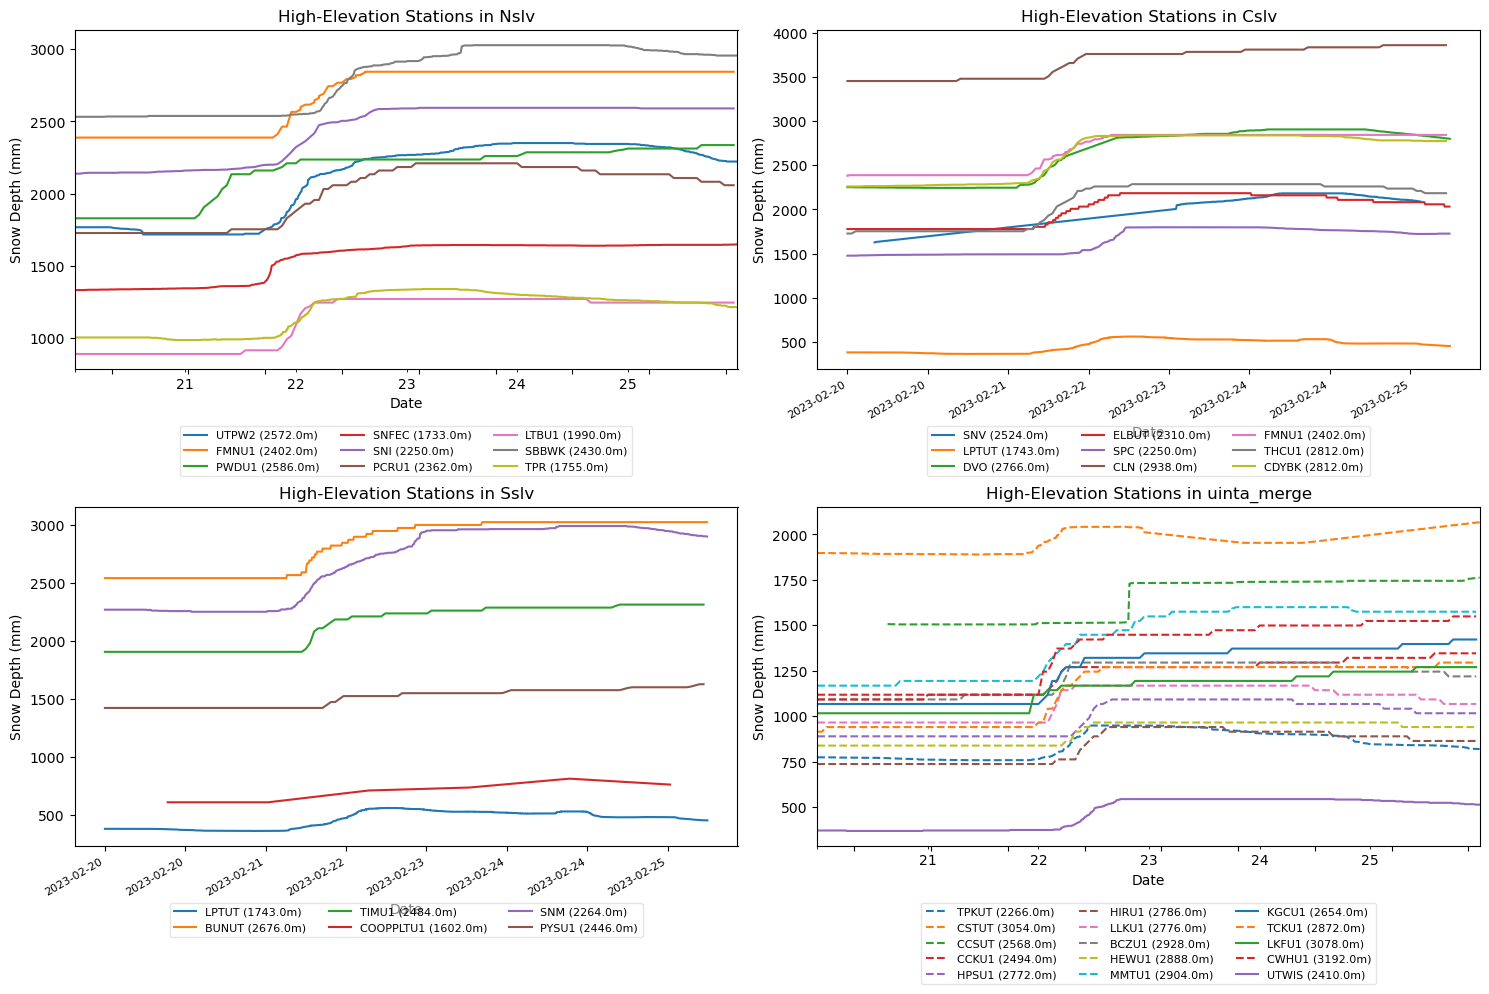

In [78]:
# Now let's identify by eye big snowfall events in the filtered_snow_depth time series 
# Start with df_2023 and we'll look at just the first month of that winter 
# Only include stid stations in sde_stids
start_str = '2023-02-20' 
end_str = '2023-02-25'
df_slice = df_2023[df_2023["stid"].isin(sde_stids)].loc[start_str:end_str]
plot_elevation_stations(df_slice, top_stations_percentage, elevation_categories,
                            ["nslv", "cslv", "sslv", ("uinta_mtns","uinta_basin")], "high")

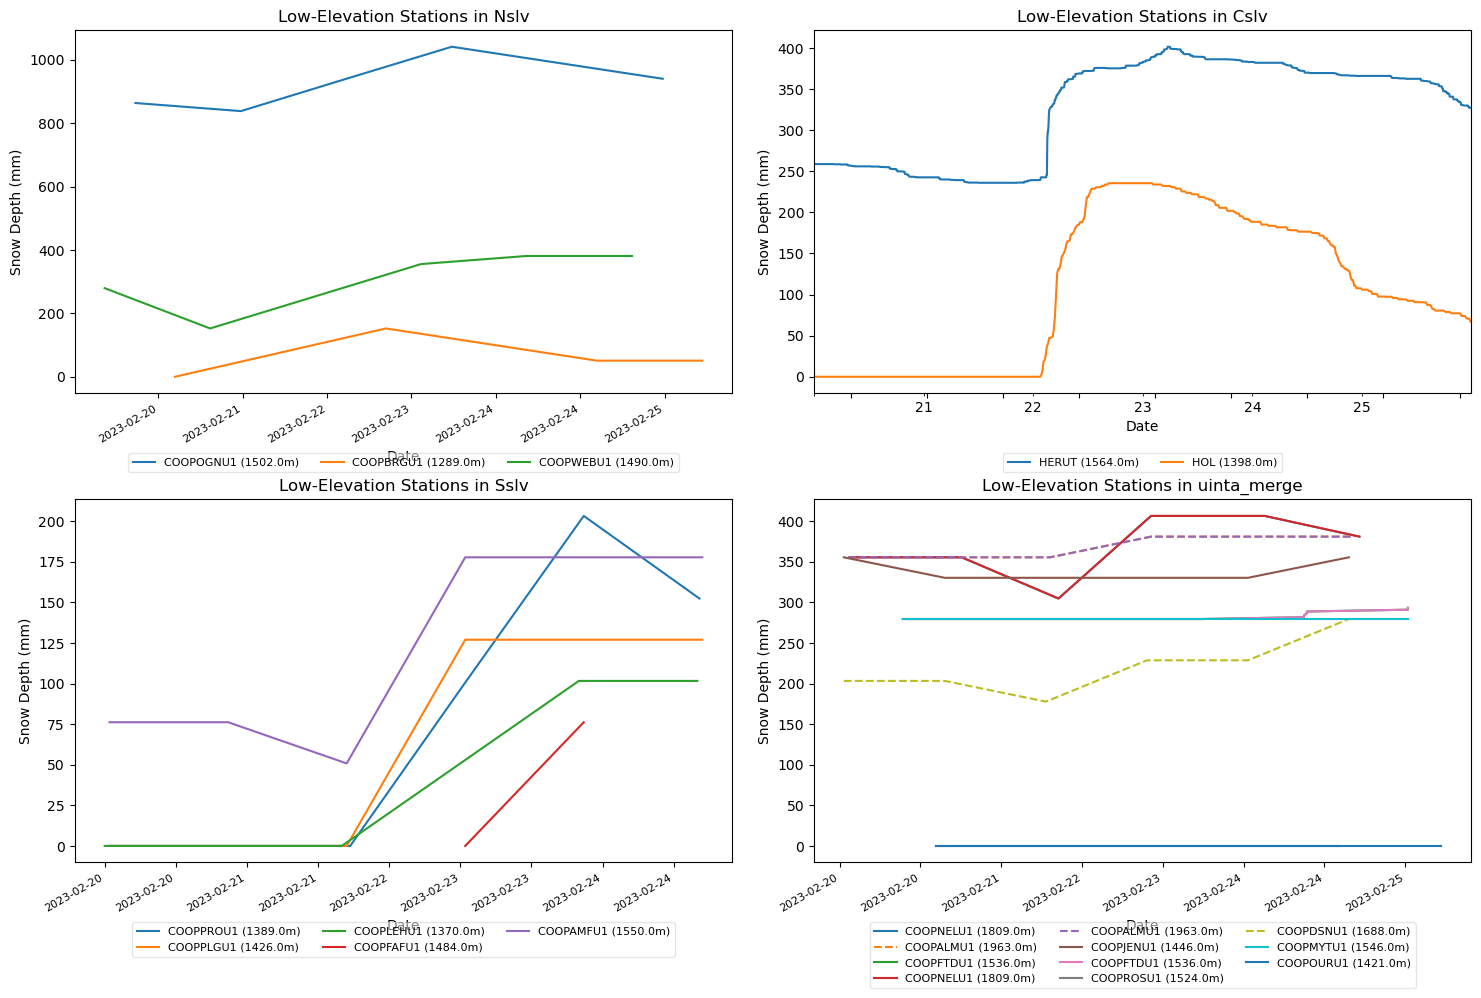

In [79]:
df_slice = df_2023[df_2023["stid"].isin(sde_stids)].loc[start_str:end_str]
plot_elevation_stations(df_slice, top_stations_percentage, elevation_categories,
                            ["nslv", "cslv", "sslv", ("uinta_mtns","uinta_basin")], "low")

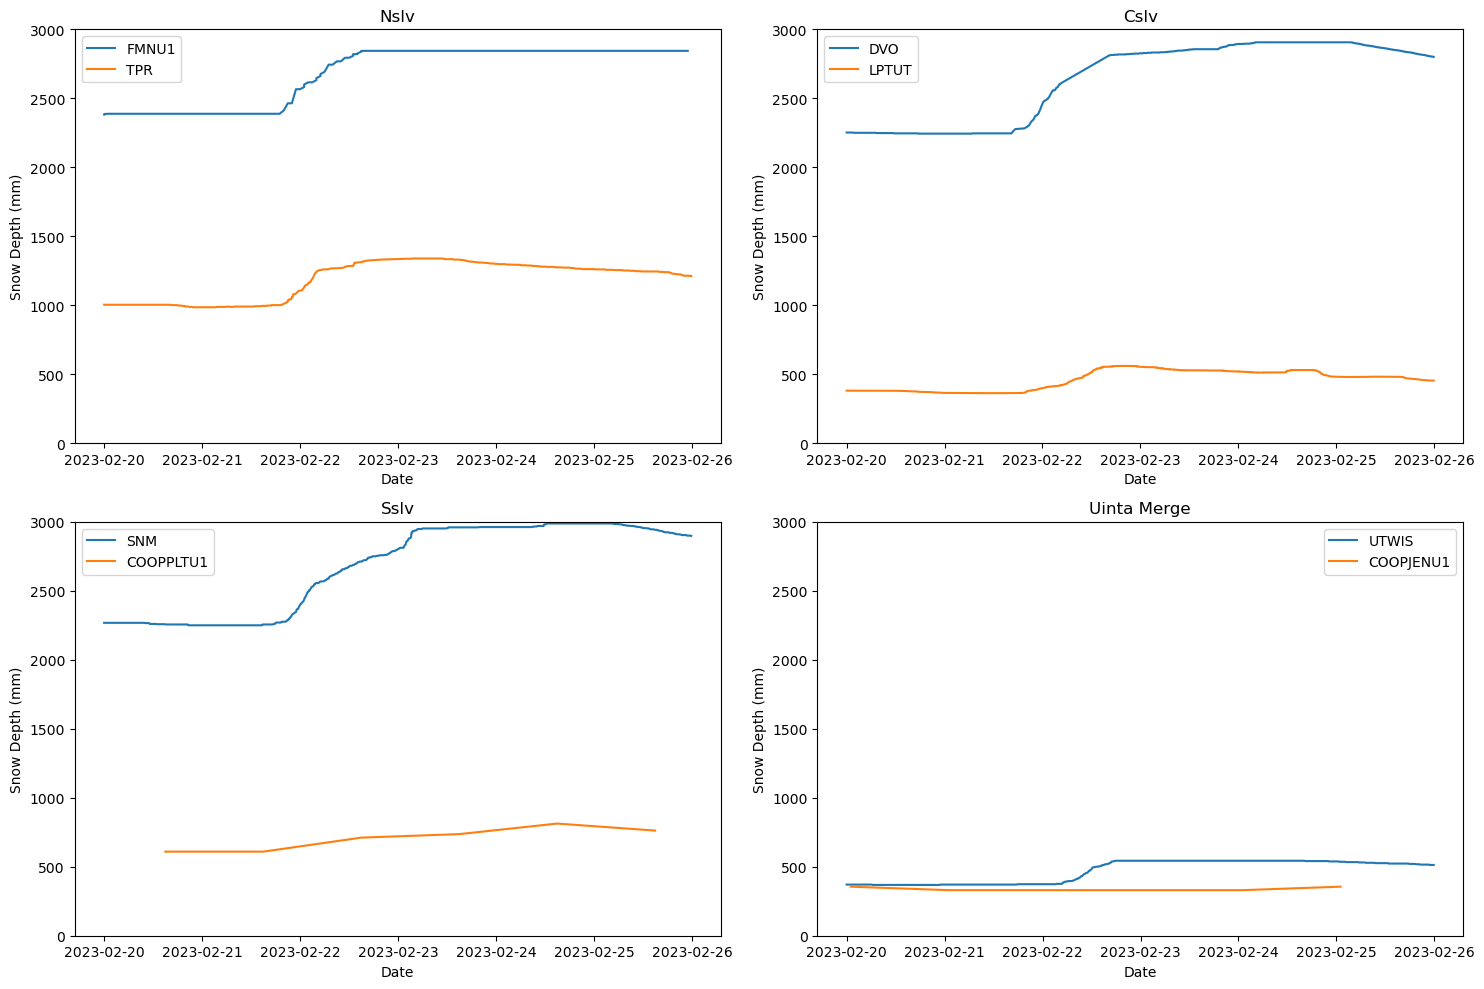

In [84]:
# Repeat last plot but only for the ['nslv', 'cslv', 'sslv', 'uinta_merge'] regions with stids ["FMNU1", "DVO", "SNM","UTWIS"] 
# On the same axes, look at lower level for same regions for stids ["TPR", "LPTUT", "COOPPLTU1", "COOPMYTU1"]

fig,axes = plt.subplots(2, 2, figsize=(15, 10))

regions = ["nslv", "cslv", "sslv", "uinta_merge"]
# High elevation stations
stids_high = ["FMNU1", "DVO", "SNM","UTWIS"]
# Low elevation stations
stids_low = ["TPR", "LPTUT", "COOPPLTU1", "COOPJENU1"]

ylim = [0,3000]

for i, ax in enumerate(axes.flat):
    stid_high = stids_high[i]
    stid_low = stids_low[i]
    df_slice_high = df_2023[df_2023["stid"].isin([stid_high])].loc[start_str:end_str]
    df_slice_low = df_2023[df_2023["stid"].isin([stid_low])].loc[start_str:end_str]
    
    ax.plot(df_slice_high.index, df_slice_high["filtered_snow_depth"], label=stid_high)
    ax.plot(df_slice_low.index, df_slice_low["filtered_snow_depth"], label=stid_low)
    
    ax.set_title(f"{regions[i].replace('_', ' ').title()}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Snow Depth (mm)")
    ax.set_ylim(ylim)
    ax.legend()

plt.tight_layout()
plt.show()
    

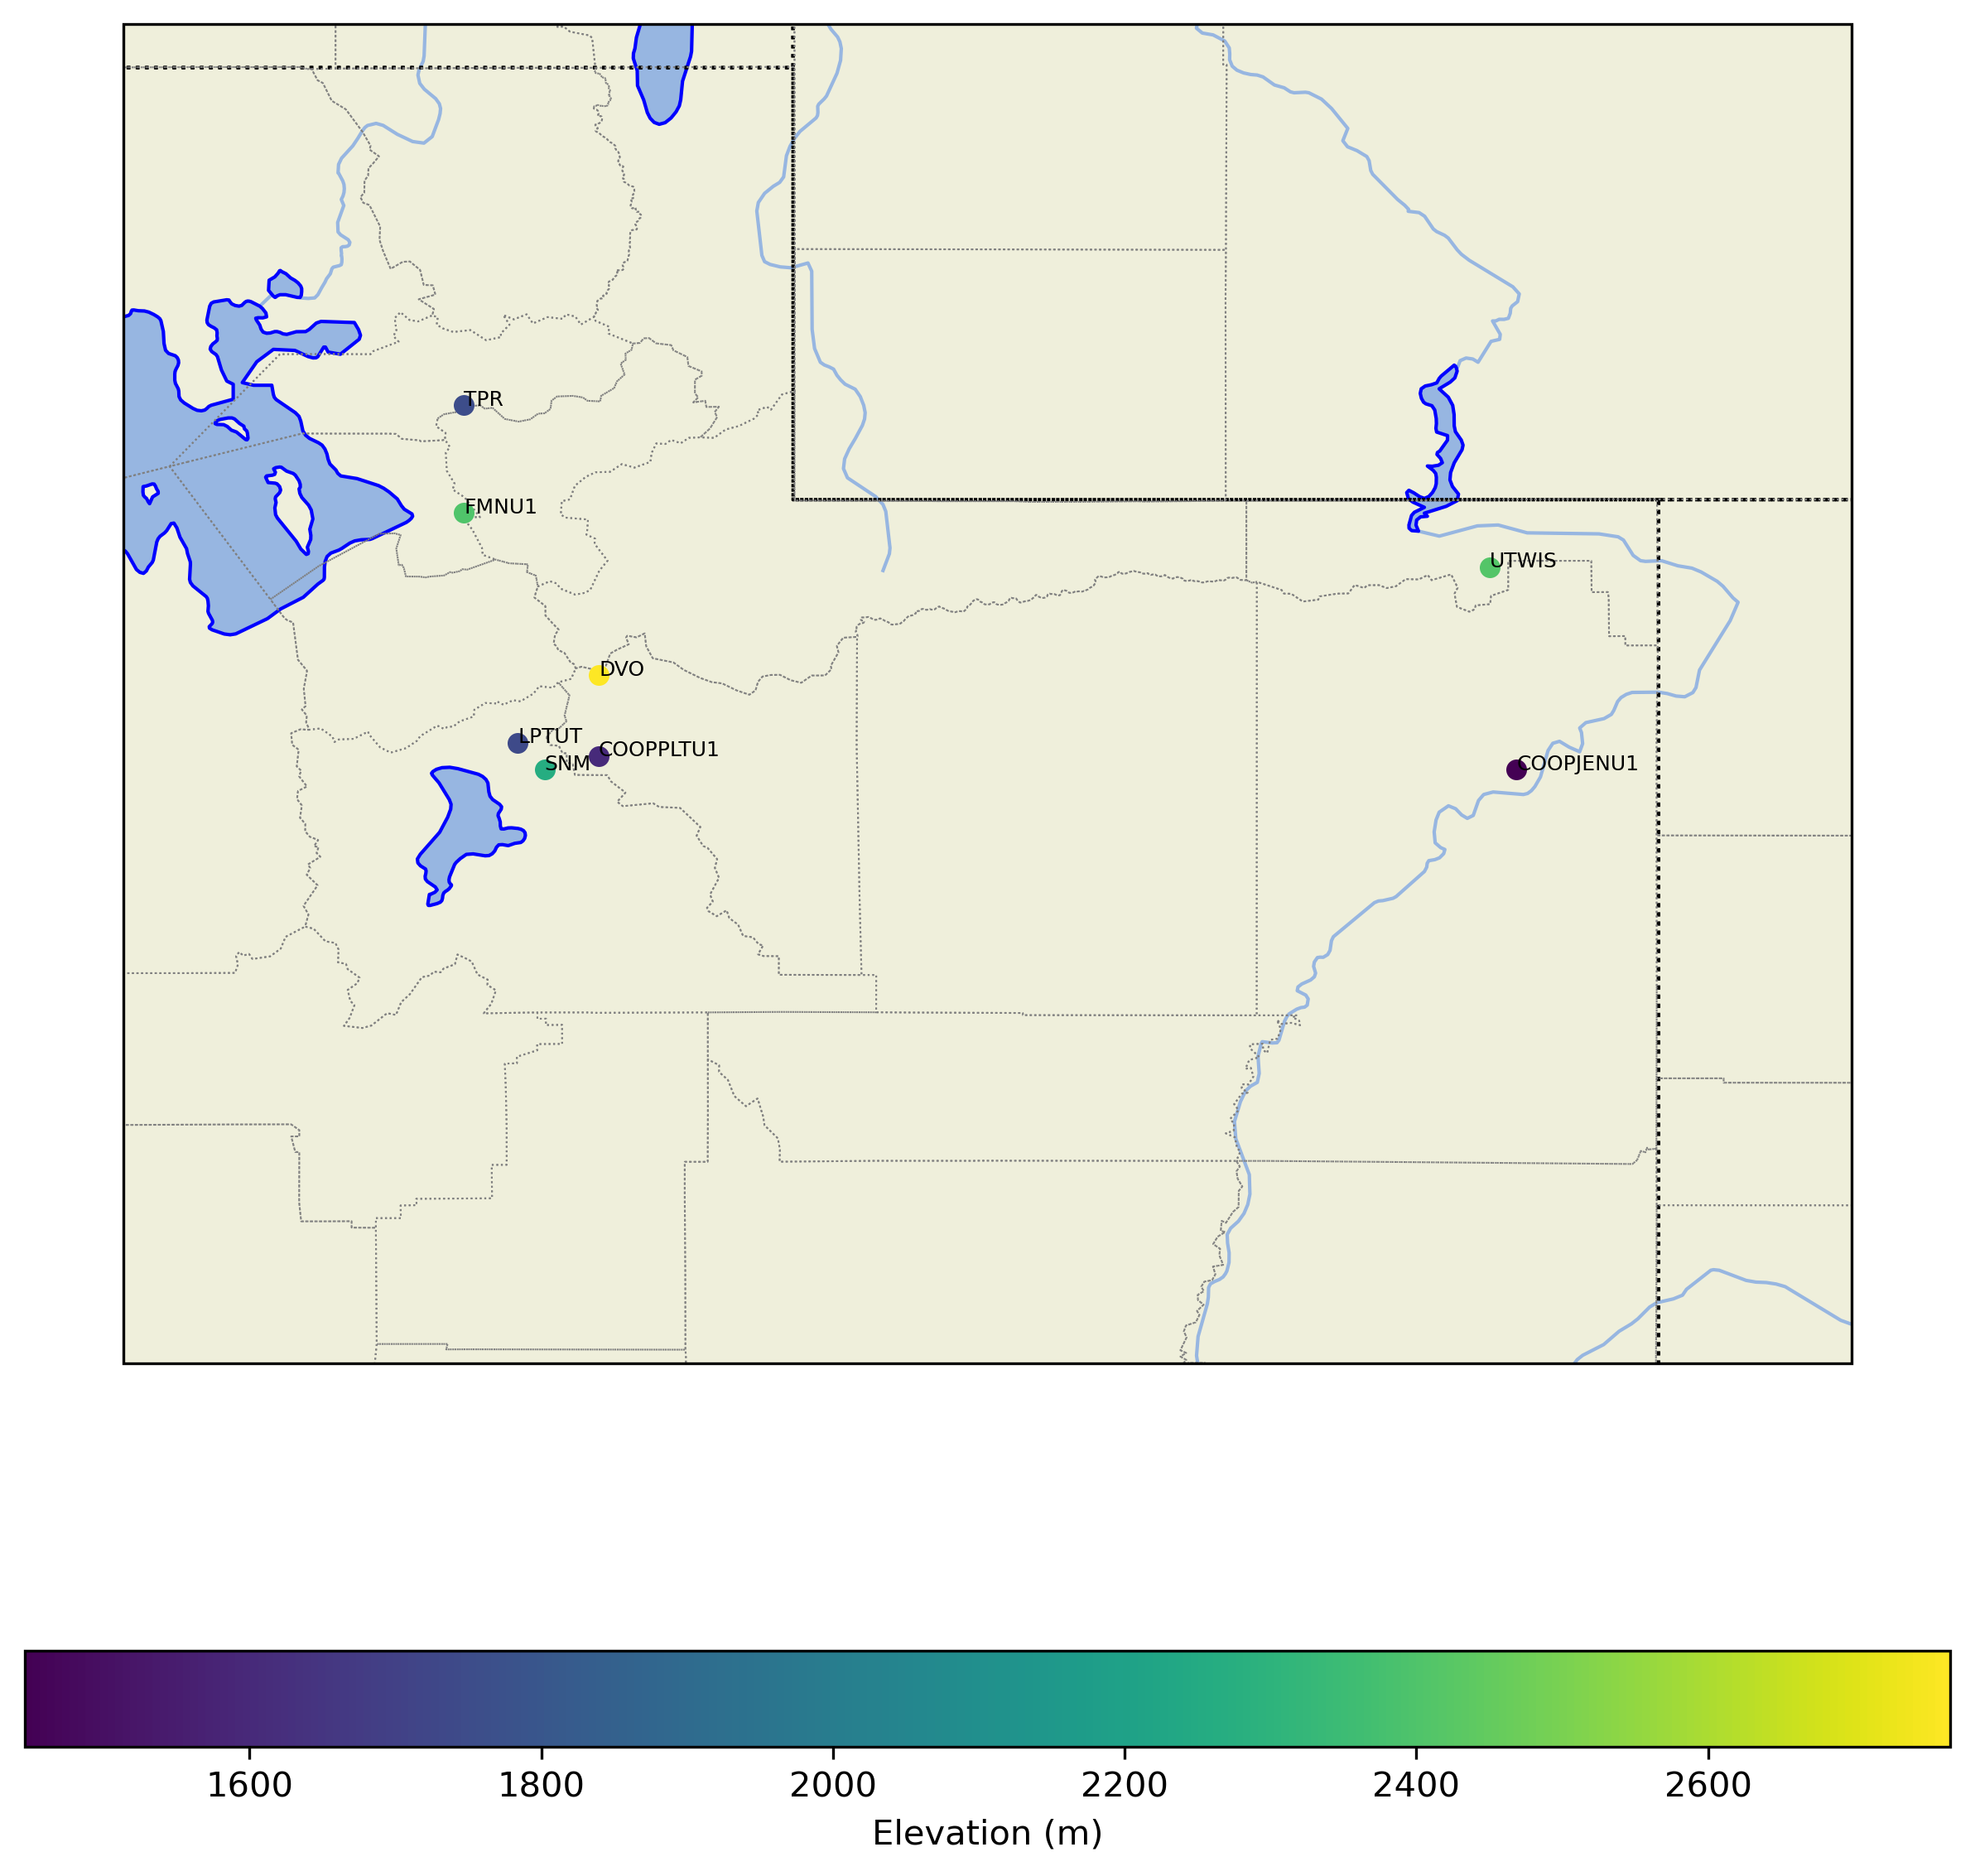

In [81]:
this_plot_stids = stids_high + stids_low

# Get a dataframe just of this to plot stations on map 
df_slice = df_2023[df_2023["stid"].isin(this_plot_stids)].loc[start_str:end_str]
be = Birdseye("./figures/casestudy1_stids_map.png", figsize=(10, 10))
be.plot_all_stations(df_slice, marker_elevation=True)


In [127]:
# Datetimes roughly in the middle of big snowfall events in SLV & Uinta Mtns
# Later we will look at relationship with Uinta Basin stations 
# TODO: for 4-panel: annotate events; dotted line for high elevation; smaller/transparent/2- or 3-column legend
# TODO: some inset for time series at low elevation to better show detail?
storm_dates = [
    ### 2022-2023 Winter ###
    datetime.datetime(2022,11,2), # looks like more so at the high elevation stations
    datetime.datetime(2022,11,6), # more of a sslv event
    datetime.datetime(2022,11,10),
    datetime.datetime(2022,11,24), # only for uinta mtns
    datetime.datetime(2022,11,29), # a big event for all levels and regions
    datetime.datetime(2022,12,12), # a big event for all levels and regions; day later for Uinta Mtns
    datetime.datetime(2022,12,22), # only seen at highest stations? Flicker at sslv BUNUT. (uinta_mtns TPKUT v CSTUT very interesting for this event)
    datetime.datetime(2022,12,28), # I think more of a high elevation event
    datetime.datetime(2023,1,1), # a big event for all levels and regions - I think a longer event, 48 for whole region (storm speed?)
    datetime.datetime(2023,1,6), # a bit later for Uinta Mtns. Less a deal for low-elev and cslv. nslv was bigger. sslv was intermittent (pysu1?!)
    datetime.datetime(2023,1,11), # a big event for all levels and regions and 48-hour event. CLN exception? Big for Uinta Mtns
    datetime.datetime(2023,1,16), # A big event with fast accumulation 
    datetime.datetime(2023,1,24), # Only in UTWIS (quite low in Uinta) and maybe other Uintas but not in SLV
    datetime.datetime(2023,1,29), # Started earlier in NSLV; contrast TIMU1 v SNM and BUNUT for difference in SSLV; only CSTUT in Uinta Mtns 
    datetime.datetime(2023,2,6), # Only really in Uintas 
    datetime.datetime(2023,2,22), # Big one for all levels and regions TODO - case study?
    datetime.datetime(2023,2,28), # Fairly large for most levels and regions - CSTUT was early for instance, weird
    datetime.datetime(2023,3,6), # Much more so in Uintas even at lower-ish levels
    datetime.datetime(2023,3,22), # 21-27 March - gradual build up of snow - not so much Uintas
    
    ### 2023-2024 Winter
    datetime.datetime(2023,11,7), # SSLV SNM; some in NSLV; good signal in CSLV; seen in Uintas too  
    datetime.datetime(2023,11,20), # Big event for all espoecially CLN and FMNU1
    datetime.datetime(2023,11,25), # SNM especially (earlier) 
    datetime.datetime(2023,12,2), # Big one for all levels and regions
    datetime.datetime(2023,12,9), # Not so big for SSLV but elsewhere 
    datetime.datetime(2023,12,24), # Only Uintas; some small signal in N/C but not S SLV
    datetime.datetime(2024,1,6), # Start on week of little dumps 
    datetime.datetime(2024,1,18), # Only for some levels and places but good signal in all regions other than CSLV
    datetime.datetime(2024,2,7), # 24- to 48-hour event for almost all regions
    datetime.datetime(2024,2,16), # Only for N/C SLV - a delay for higher elevations? Some signal in Uintas 
    datetime.datetime(2024,2,20), # Mainly for high elevs especially in NSLV - accumulation more gradual in Uintas 
    datetime.datetime(2024,2,27), # Huge at BUNUT (SSLV) and decent at top two UM stids, I think CSTUT, CCSUT (Uinta Mtns) - not so much elsewhere
    datetime.datetime(2024,3,3), # Big for all regions and levels
    datetime.datetime(2024,3,13), # Decent event for all regions - later for Uintas
    
]

storm_dates = [sd.replace(tzinfo=pytz.UTC) for sd in storm_dates]

In [135]:
# Go through each datetime, gather the data for +/- 24 hours either side (df_2023 or df_2024 depending on before/after May 2023, respectively)
# We want to look at aggregate stats of:
# (a) snow depth between high/low elevation in Uinta Basin
# (b) snow depth between similar elevations/stids between SLV and Uinta area
# (c) predominent wind direction for each event - does this correlate with snowfall differences?

# Reminder of areas
# regions = ["nslv", "cslv", "sslv", "uinta_merge"]
# stids_high = ["FMNU1", "DVO", "SNM","UTWIS"]
# stids_low = ["TPR", "LPTUT", "COOPPLTU1", "COOPJENU1"]

# Create a dictionary to store stats; this becomes a dataframe with regions as columns, storm dates as rows.
diff_dict = {region: [] for region in regions}
ratio_dict = {region: [] for region in regions}

for sd in storm_dates:
    start_date = sd - datetime.timedelta(days=1)
    end_date = sd + datetime.timedelta(days=1)

    if start_date < datetime.datetime(2023, 5, 1, tzinfo=pytz.UTC):
        df_slice = df_2023.loc[start_date:end_date]
    else:
        df_slice = df_2024.loc[start_date:end_date]

    for region, stid_high, stid_low in zip(regions, stids_high, stids_low):
        # Compute snow depth change for high elevation
        try:
            high_start_val = df_slice[df_slice["stid"] == stid_high]["filtered_snow_depth"].iloc[0]
            high_end_val = df_slice[df_slice["stid"] == stid_high]["filtered_snow_depth"].iloc[-1]
            high_diff = high_end_val - high_start_val
        except IndexError:
            high_diff = np.nan  # Handles case where data might be missing

        # Compute snow depth change for low elevation
        try:
            low_start_val = df_slice[df_slice["stid"] == stid_low]["filtered_snow_depth"].iloc[0]
            low_end_val = df_slice[df_slice["stid"] == stid_low]["filtered_snow_depth"].iloc[-1]
            low_diff = low_end_val - low_start_val
        except IndexError:
            low_diff = np.nan  # Handles case where data might be missing

        # Compute difference in accumulation
        accum_diff = high_diff - low_diff
        diff_dict[region].append(accum_diff)

        # Compute ratio, handling division by zero or missing data
        if low_diff == 0 or np.isnan(low_diff) or np.isnan(high_diff):
            ratio_dict[region].append(np.nan)
        else:
            ratio_dict[region].append(high_diff / low_diff)
        
    
# Create a dataframe from the difference dictionary
storm_diffs = pd.DataFrame(diff_dict, index=storm_dates)

# And for the ratio dictionary
# TODO - this is rubbish, need to create better method 
storm_ratios = pd.DataFrame(ratio_dict, index=storm_dates)

# Make dataframe render with only 1 decimal place
pd.options.display.float_format = '{:.1f}'.format

pass
storm_diffs

,nslv,cslv,sslv,uinta_merge
2022-11-02 00:00:00+00:00,156.6,285.3,124.7,15.2
2022-11-06 00:00:00+00:00,-44.5,62.0,127.0,-53.3
2022-11-10 00:00:00+00:00,83.1,302.0,166.6,86.4
2022-11-24 00:00:00+00:00,-10.1,21.0,-0.8,-2.6
2022-11-29 00:00:00+00:00,32.8,199.6,57.9,50.9
2022-12-12 00:00:00+00:00,-9.1,-42.9,200.2,175.2
2022-12-22 00:00:00+00:00,-114.5,131.8,26.0,-5.0
2022-12-28 00:00:00+00:00,198.8,377.9,272.6,-38.0
2023-01-01 00:00:00+00:00,282.2,594.0,512.8,134.8
2023-01-06 00:00:00+00:00,7.0,24.2,105.2,12.8


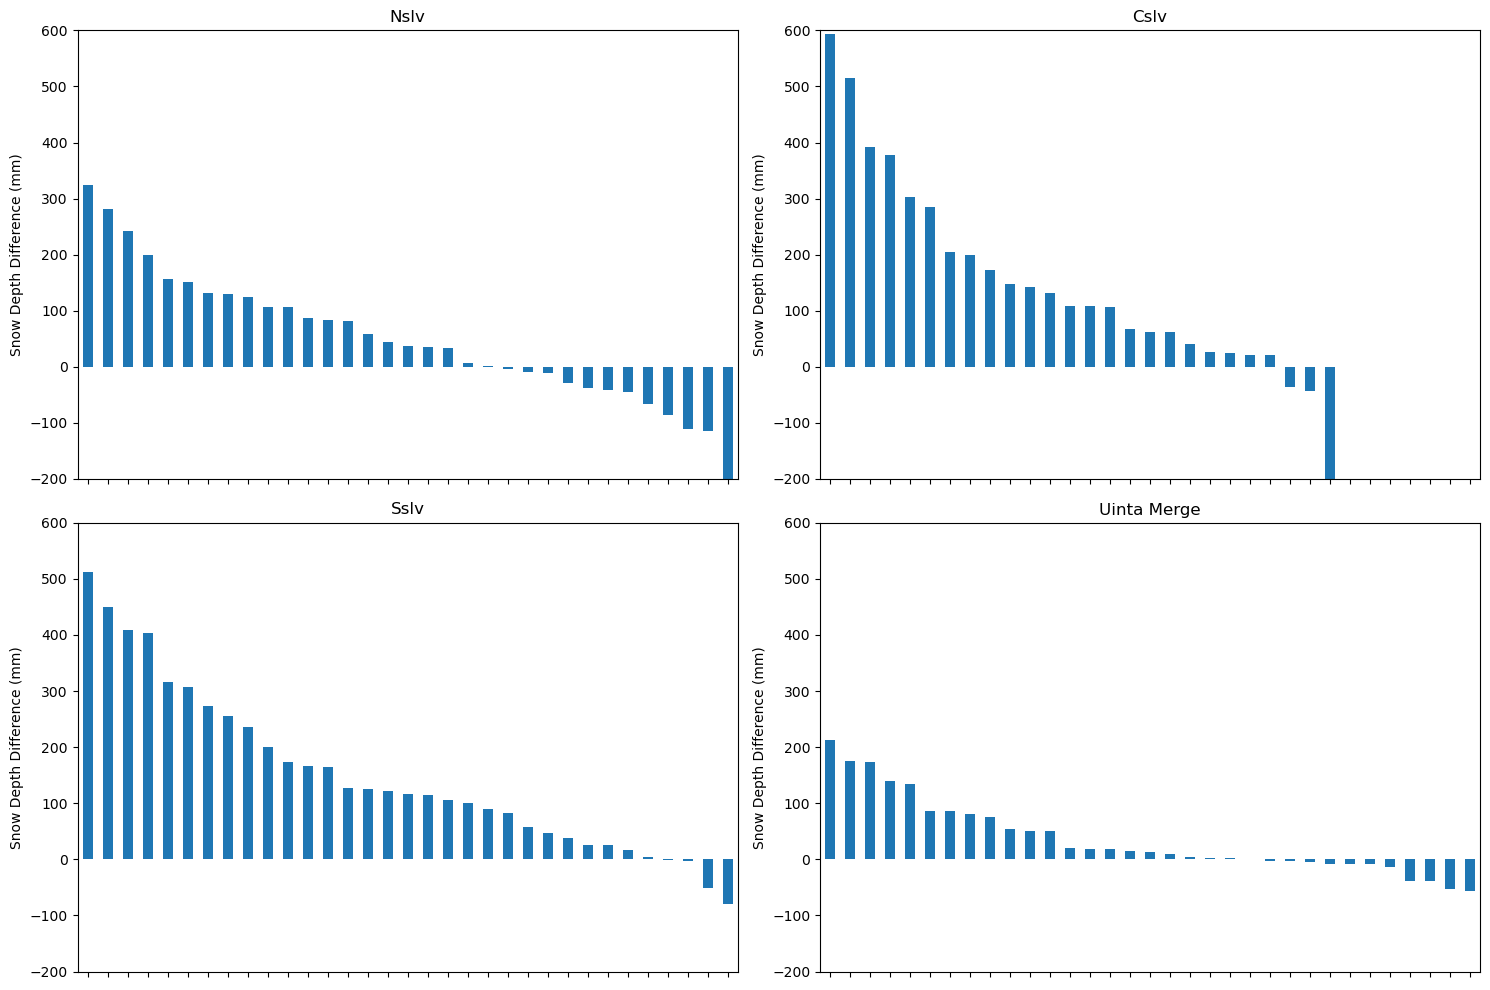

In [136]:
# Now create a 2x2 multi-panel plot where each axis is a region
# Sort the stats per region so they are in descending order (mm)
# Use bar charts for each event and show the difference in snow depth between high/low elevation in the four regions

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, region in enumerate(regions):
    storm_diffs[region].sort_values(ascending=False).plot(kind='bar', ax=axes[i // 2, i % 2])
    axes[i//2, i%2].set_title(f"{region.replace('_', ' ').title()}")
    axes[i//2, i%2].set_xlabel("")
    axes[i//2, i%2].set_ylabel("Snow Depth Difference (mm)")
    
    axes[i//2, i%2].set_xticklabels([])
    axes[i//2, i%2].set_ylim([-200, 600])
    
plt.tight_layout()
plt.show()

In [137]:
# Placeholder for collected data
collected_data = []

for sd in storm_dates:
    start_date = sd - datetime.timedelta(days=1)
    end_date = sd + datetime.timedelta(days=1)

    if start_date < datetime.datetime(2023, 5, 1, tzinfo=pytz.UTC):
        df_slice = df_2023.loc[start_date:end_date]
    else:
        df_slice = df_2024.loc[start_date:end_date]
    
    for region, stid_high, stid_low in zip(regions, stids_high, stids_low):
        # Initialize variables to NaN in case data is missing
        high_diff = np.nan
        low_diff = np.nan

        # Filter the dataframe for the high and low stations
        df_high = df_slice[df_slice["stid"] == stid_high]
        df_low = df_slice[df_slice["stid"] == stid_low]
        
        if not df_high.empty:
            high_diff = df_high["filtered_snow_depth"].iloc[-1] - df_high["filtered_snow_depth"].iloc[0]
        
        if not df_low.empty:
            low_diff = df_low["filtered_snow_depth"].iloc[-1] - df_low["filtered_snow_depth"].iloc[0]
        
        # Compute difference in accumulation between high and low elevation
        accum_diff = high_diff - low_diff
        
        # Append data for this storm and region
        collected_data.append({
            "Storm_Date": sd,
            "Region": region,
            "Snow_Depth_Difference": accum_diff,
        })

# Convert the collected data into a DataFrame
storm_data = pd.DataFrame(collected_data)
# Add a sequential storm number for each unique storm date
storm_data['Storm_Number'] = storm_data['Storm_Date'].rank(method='dense').astype(int)

# Assuming you no longer need the 'Storm_Date' column for plotting, you can drop or ignore it
storm_data.drop(columns=['Storm_Date'], inplace=True)

storm_data 

,Region,Snow_Depth_Difference,Storm_Number
0,nslv,156.6,1
1,cslv,285.3,1
2,sslv,124.7,1
3,uinta_merge,15.2,1
4,nslv,-44.5,2
...,...,...,...
127,uinta_merge,0.0,32
128,nslv,107.0,33
129,cslv,NaN,33
130,sslv,116.6,33


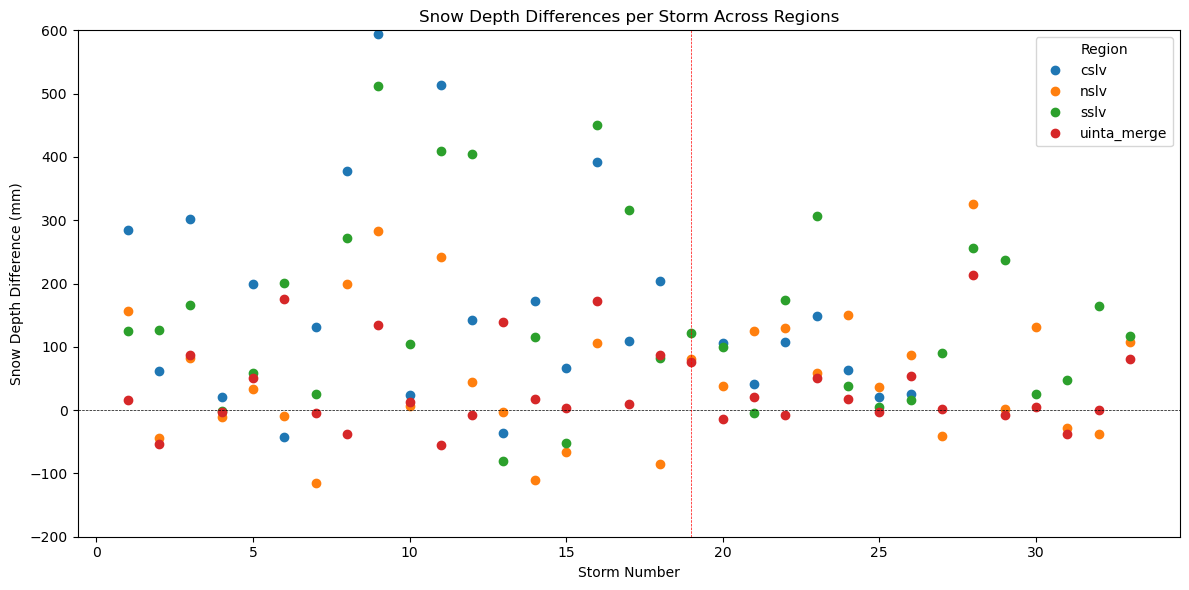

In [141]:

# Pivot the data for easier plotting with Storm_Number as the index
pivot_df = storm_data.pivot(index='Storm_Number', columns='Region', values='Snow_Depth_Difference')

# The divider between seasons in (2023, 5, 1)
# Use this to find the first storm of the 2023-2024 winter season from storm_dates
first_storm_index = storm_dates.index([sd for sd in storm_dates if sd >= datetime.datetime(2023, 5, 1, tzinfo=pytz.UTC)][0])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
for region in pivot_df.columns:
    ax.plot(pivot_df.index, pivot_df[region], marker='o', linestyle='None', label=region)  # Use 'None' for linestyle to only show markers

ax.set_title('Snow Depth Differences per Storm Across Regions')
ax.set_xlabel('Storm Number')
ax.set_ylabel('Snow Depth Difference (mm)')
ax.legend(title='Region')
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Add a horizontal line at y=0 for reference
ax.axvline(first_storm_index, color='red', linestyle='--', linewidth=0.5)  # Add a vertical line at the first storm of 2023-2024
ax.set_ylim([-200, 600])

plt.tight_layout()
plt.show()

In [ ]:
# Algorithm to detect big snowfall events by >75mm increase in snow_depth in 24 hours for stids ["CLN", "PWDU1", "CSTUT", "BUNUT"]
# These are four high-altitude stations in each four mountain regions (i.e., not the basin)
# We will plot the filtered_snow_depth time series for these stations, and mark the big snowfall events

# Define the stations of interest
stids = ["CLN", "PWDU1", "CSTUT", "BUNUT"]



In [1]:
# Can classify into mainly western and mainly northerly - i.e. Wasatch v Uintas for blocking flow or the snow-shadow effect
# Is there a change in patterns as function of main flow direction?

In [2]:
stid = "CSTUT"
vrbl = "snow_depth"
filtered_df2 = apply_median_filter(replace_max_values(df_2024, stid, vrbl), stid, vrbl, kernel_size=11)
plot_before_after(df_2024, stid, vrbl, filtered_df2)

NameError: name 'apply_median_filter' is not defined

In [ ]:
filtered_df2 = apply_median_filter(replace_max_values(df_2024, stid, vrbl), stid, vrbl, kernel_size=501)
plot_before_after(df_2024, stid, vrbl, filtered_df2)

In [ ]:
stid = "SNFEC"
filtered_df2 = apply_median_filter(replace_max_values(df_2024, stid, vrbl), stid, vrbl, kernel_size=501)
plot_before_after(df_2024, stid, vrbl, filtered_df2)

In [ ]:
# Plot time series of snow_depth for a specific stid 
stid = "CSTUT"
df_obs_winter[df_obs_winter["stid"] == stid].plot(y="snow_depth")
plt.title(f"Snow Depth Time Series for STID: {stid}")
plt.ylabel("Snow Depth (mm)")
plt.xlabel("Date")
plt.show()

In [ ]:
filter_and_plot_data(df_2024, top_stations_percentage, "uinta_mtns", kernel_size=101)

### We shall use these stations as snow-depth stations for our representative obs 
We need to run filters for the noisy data - we will test each one to see if one kernel works for all, etc.

* Uinta Mountains: CWHU1 is in forest, close to crest; 
* Uinta Basin: MMTU1 is foothills. COOPNELU1 is Neola. COOPALMU1 is Altamont. COOPJENU1 is Jensen. COOPFTDU1 is Fort Duchesne.
* Northern Salt Lake Valley: 
* Central Salt Lake Valley:
* Southern Salt Lake Valley:



In [ ]:
pass

### Final findings and thoughts
I think:
* Uinta Basin needs more stations that measure snow depth, especially in lee of Wasatch where snow shadowing is more likely
* The COOP stations were surprisingly low for 2024 but high for 2023?
* Duschesne also has strong winds - snow eater? 
* We need to consider the snow shadow effect form north